# Add injury to insult
#### A case study of murdering someone with the right choice of words

### Attacker
Nyah, level 5 witch (The Resentment)
**Skills** Diplomacy +14 (Bon Mot)

**Occult Spells** DC 21; **3rd** Blindness, Biting Words; **2nd** Blistering Invective; **1st** Sure Strike x3 ; **Cantrips (3rd)** Evil Eye

### Attack routine
1. Bon Mot, Blistering Invective
2. Blindness, Evil Eye
3. Evil Eye or Sure Strike, Biting Words
4. Evil Eye, Sure Strike, Biting Words attack
5. Evil Eye, Sure Strike, Biting Words attack

### Assumptions
- The target attempts to clear neither Bon Mot nor Sickened
- No movement is needed; the target remains within 30ft at all time
- Spellcasting is not disrupted or obstructed in any way
- Ignoring damage dealt to other creatures by casting heightened blistering invective

In [1]:
import numpy as np
import xarray
from pathfinder2e_stats import *

np.random.seed(0)

diplomacy = 14
spell_DC = 21

# You can change any of these to upcast or downcast them;
# damage and incapacitation trait are adjusted automatically
blistering_invective_rank = 2
blindness_rank = 3
biting_words_rank = 3

## Targets

In [2]:
targets = xarray.Dataset(
    {
        "target": [
            "The Stag Lord",
            "Ettin",
            "Hill Giant",
            "Vampire Count",
            "Dweomercat",
        ],
        "level": ("target", [6, 6, 7, 6, 7]),
        "HP": ("target", [110, 110, 140, 65, 100]),
        "AC": ("target", [23, 21, 24, 24, 25]),
        "Will": ("target", [9, 12, 13, 17, 17]),
        "bonus_save_vs_magic": ("target", [0, 0, 0, 0, 1]),
        "sickened": ("target", [1, 0, 0, 0, 0]),
    }
)
targets["rank"] = level2rank(targets.level)
targets.to_pandas()

,level,HP,AC,Will,bonus_save_vs_magic,sickened,rank
target,,,,,,,
The Stag Lord,6,110,23,9,0,1,3
Ettin,6,110,21,12,0,0,3
Hill Giant,7,140,24,13,0,0,4
Vampire Count,6,65,24,17,0,0,3
Dweomercat,7,100,25,17,1,0,4


## Round 1: Bon Mot -> Blistering Invective

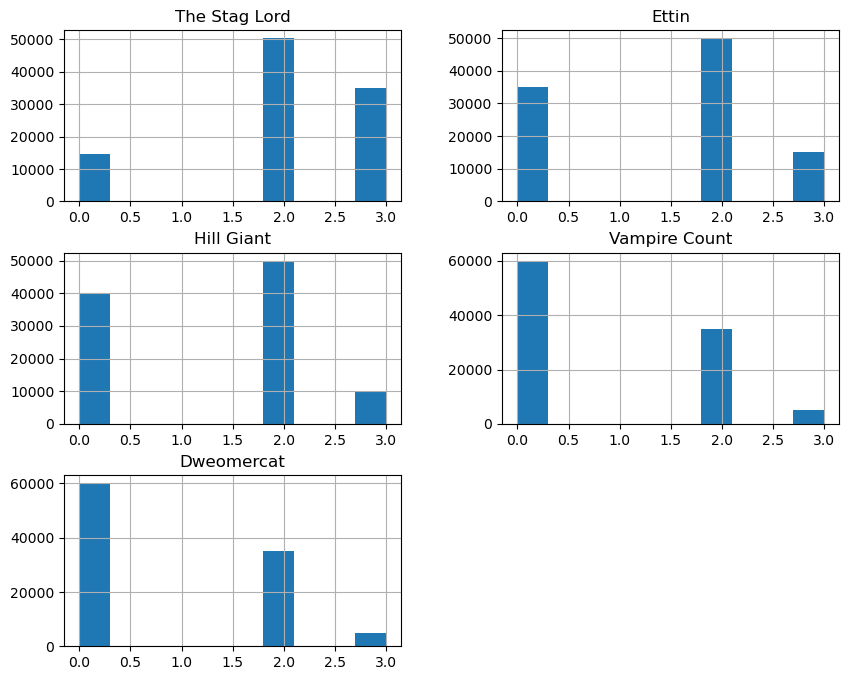

In [3]:
bon_mot = check(diplomacy, DC=targets.Will + 10 - targets.sickened)
bon_mot["Will_penalty"] = xarray.where(
    bon_mot.outcome == DoS.critical_success, 3,
    xarray.where(bon_mot.outcome == DoS.success, 2, 0)
)
_ = bon_mot.Will_penalty.to_pandas().hist(figsize=(10, 8))

In [4]:
sickened = [
    targets.sickened
]
will = [
    sum_bonuses(
        ("untyped", targets.Will),
        ("status", targets.bonus_save_vs_magic),
        ("status", -targets.sickened),
        ("status", -bon_mot.Will_penalty),
    )
]

blistering_invective = damage(
    check(will[0], DC=spell_DC),
    Damage("fire", blistering_invective_rank // 2 * 2, 6, persistent=True, basic_save=True),
    persistent_damage_rounds=5
).rename({"persistent_round": "round"})

blistering_invective_damage = blistering_invective["persistent_damage"].where(
    blistering_invective["apply_persistent_damage"], 0
).sum("damage_type")
blistering_invective_damage.mean("roll").to_pandas().T

target,The Stag Lord,Ettin,Hill Giant,Vampire Count,Dweomercat
round,,,,,
0,7.01174,5.18965,4.85302,3.30539,2.96167
1,4.90901,3.64111,3.40304,2.31008,2.07076
2,3.41427,2.53463,2.36940,1.61399,1.44693
3,2.41098,1.78437,1.66736,1.13354,1.01670
4,1.69569,1.25273,1.17292,0.80113,0.71689


In [5]:
frightened = xarray.where(
    blistering_invective.outcome == DoS.failure, 1,
    xarray.where(blistering_invective.outcome == DoS.critical_failure, 2, 0)
)
frightened.isel(roll=0)
frightened = np.maximum(0, frightened - blistering_invective["round"])

## Round 2: Blindness -> Evil Eye
Blindness is a rank 3+ spell with the incapacitation trait. level 7+ targets get the success of their saves one step better. Evil Eye is used to extend the duration.

In [6]:
# TODO: write tool to make bonus/penalty sums easier
def maximum(*args):
    out = args[0]
    for rhs in args[1:]:
        out = np.maximum(out, rhs)
    return out

will.append(
    sum_bonuses(
        ("untyped", targets.Will),
        ("status", targets.bonus_save_vs_magic),
        ("status", -sickened[-1]),
        ("status", -bon_mot.Will_penalty),
        ("status", -frightened.isel(round=1, drop=True)),
    )
)
# TODO: pass incapacitation DataArray directly to check(..., incapacitation=...)
incapacitation = targets["rank"] > blindness_rank
blindness = check(will[-1], DC=spell_DC)
blindness["outcome"] = np.minimum(DoS.critical_success, blindness.outcome + incapacitation)

# In case of simple success, we use Evil Eye to extend the blindness for the whole combat
blindness["need_evil_eye"] = blindness.outcome == DoS.success
blindness["blind"] = blindness.outcome < DoS.critical_success
blindness

<xarray.Dataset> Size: 10MB
Dimensions:        (target: 5, roll: 100000)
Coordinates:
  * target         (target) <U13 260B 'The Stag Lord' 'Ettin' ... 'Dweomercat'
Dimensions without coordinates: roll
Data variables:
    bonus          (target, roll) int64 4MB 7 6 8 7 7 7 7 ... 18 18 17 17 18 18
    DC             int64 8B 21
    natural        (roll) int64 800kB 11 16 9 15 9 14 16 ... 13 5 7 19 11 19 2
    outcome        (roll, target) int64 4MB 0 1 2 1 2 1 1 2 ... 2 2 2 -1 0 1 0 1
    need_evil_eye  (roll, target) bool 500kB False True False ... False True
    blind          (roll, target) bool 500kB True True False ... True True True
Attributes:
    keen:          False
    fortune:       False
    misfortune:    False
    hero_point:    False
    map_outcomes:  {}
    legend:        {-2: 'No roll', -1: 'Critical failure', 0: 'Failure', 1: '...

In [7]:
def evil_eye(will_bonus, spell_DC, mask=None):
    c = check(will_bonus, DC=spell_DC)
    if mask is not None:
        c = c.where(mask, DoS.no_roll)
    return xarray.where(
        c.outcome == DoS.critical_failure, 2,
        xarray.where(c.outcome == DoS.failure, 1, 0),
    )

sickened.append(
    np.maximum(sickened[-1], evil_eye(will[-1], spell_DC))
)

In [8]:
blindness.mean("roll")[["blind", "need_evil_eye"]].to_pandas()

,blind,need_evil_eye
target,,
The Stag Lord,0.95098,0.29463
Ettin,0.93360,0.46124
Hill Giant,0.41596,0.36478
Vampire Count,0.69019,0.49662
Dweomercat,0.14335,0.09217


### Round 3: Evil Eye or Sure Strike -> Biting Words
If the target scored a simple success vs. Blindness in round 2, extend its duration with Evil Eye.
Otherwise, cast Sure Strike. Then, cast Biting Words.
### Round 4 and 5: Evil Eye -> Sure Strike -> Biting Words attack

In [9]:
for rnd in range(3, 6):
    will.append(
        sum_bonuses(
            ("untyped", targets.Will),
            ("status", targets.bonus_save_vs_magic),
            ("status", -sickened[-1]),
            ("status", -bon_mot.Will_penalty),
        )
    )
    evil_eye_mask = blindness.need_evil_eye if rnd == 3 else None
    sickened.append(
        np.maximum(
            sickened[-1],
            evil_eye(will[-1], spell_DC, mask=evil_eye_mask)
        )
    )

assert len(will) == 5
assert len(sickened) == 5

will = xarray.concat(will, dim="round")
sickened = xarray.concat(sickened, dim="round")

In [10]:
off_guard = xarray.concat(
    [
        xarray.DataArray(False),
        blindness.blind.expand_dims(round=4),
    ],
    dim="round"
)
AC = sum_bonuses(
    ("untyped", targets.AC),
    ("status", -frightened),
    ("status", -sickened),
    ("circumstance", off_guard * -2),
)
AC.mean("roll").to_pandas()

round,0,1,2,3,4
target,,,,,
The Stag Lord,21.79318,19.88816,19.84044,19.68592,19.56538
Ettin,20.47169,18.57397,18.46445,18.21891,18.06882
Hill Giant,23.53667,22.67657,22.59829,22.34982,22.18642
Vampire Count,23.76127,22.33777,22.27574,22.09357,21.94039
Dweomercat,24.81050,24.47873,24.50295,24.33984,24.19750


In [11]:
# TODO allow check(... fortune=...) with DataArray parameter
biting_words_check = check(spell_DC - 10, DC=AC, dims={"fortune": 2})
biting_words_check["outcome"] = xarray.concat(
    [
        xarray.DataArray([DoS.no_roll, DoS.no_roll], dims=["round"]),
        xarray.where(
            blindness.need_evil_eye,
            biting_words_check["outcome"].isel(round=2, fortune=0),
            biting_words_check["outcome"].isel(round=2).max("fortune"),
        ),
        biting_words_check["outcome"].isel(round=[3, 4]).max("fortune"),
    ],
    dim="round",
)

biting_words_damage = damage(
    biting_words_check,
    Damage("sonic", biting_words_rank * 2, 6)
).total_damage
biting_words_damage.mean("roll").T.to_pandas()

round,0,1,2,3,4
target,,,,,
The Stag Lord,0.0,0.0,19.99095,22.49152,22.78601
Ettin,0.0,0.0,21.92141,26.06616,26.41545
Hill Giant,0.0,0.0,14.85656,17.45410,17.67148
Vampire Count,0.0,0.0,14.42783,17.80688,18.02297
Dweomercat,0.0,0.0,14.26647,15.01826,15.19266


In [12]:
final = xarray.Dataset(
    {
        "AC": AC,
        "Will": will,
        "blind": blindness.blind,
        "need_evil_eye": blindness.need_evil_eye,
        "blistering_invective": blistering_invective_damage,
        "biting_words": biting_words_damage,
        "total_damage": blistering_invective_damage + biting_words_damage,
    }
).transpose("target", "roll", "round")
final["harmed"] = final.total_damage.sum("round") > 0
final["bloodied"] = final.total_damage.sum("round") > targets.HP // 2
final["killed"] = final.total_damage.sum("round") >= targets.HP
final

<xarray.Dataset> Size: 103MB
Dimensions:               (target: 5, roll: 100000, round: 5)
Coordinates:
  * target                (target) <U13 260B 'The Stag Lord' ... 'Dweomercat'
Dimensions without coordinates: roll, round
Data variables:
    AC                    (target, roll, round) int64 20MB 22 20 20 ... 23 23 23
    Will                  (target, roll, round) int64 20MB 7 7 7 7 ... 18 18 18
    blind                 (target, roll) bool 500kB True True ... False True
    need_evil_eye         (target, roll) bool 500kB False True ... False True
    blistering_invective  (target, roll, round) int64 20MB 8 0 0 0 0 ... 0 0 0 0
    biting_words          (target, roll, round) int64 20MB 0 0 21 21 ... 0 28 28
    total_damage          (target, roll, round) int64 20MB 8 0 21 21 ... 0 28 28
    harmed                (target, roll) bool 500kB True True ... False True
    bloodied              (target, roll) bool 500kB True True ... False True
    killed                (target, roll) bool 500kB False False ... False False

In [13]:
final.mean("roll").sum("round")[["blistering_invective", "biting_words", "total_damage"]].to_pandas().T

target,The Stag Lord,Ettin,Hill Giant,Vampire Count,Dweomercat
blistering_invective,19.44169,14.40249,13.46574,9.16413,8.21295
biting_words,65.26848,74.40302,49.98214,50.25768,44.47739
total_damage,84.71017,88.80551,63.44788,59.42181,52.69034


In [14]:
# Mean damage, by round
final.mean("roll")["total_damage"].to_pandas()

round,0,1,2,3,4
target,,,,,
The Stag Lord,7.01174,4.90901,23.40522,24.90250,24.48170
Ettin,5.18965,3.64111,24.45604,27.85053,27.66818
Hill Giant,4.85302,3.40304,17.22596,19.12146,18.84440
Vampire Count,3.30539,2.31008,16.04182,18.94042,18.82410
Dweomercat,2.96167,2.07076,15.71340,16.03496,15.90955


- Probability of dealing any HP damage at all
- Probability of dealing more than 50% HP damage
- Probability of solo killing the target
- Probability of blinding the target in round 2
- Probability of needing to spam evil eye every round to keep them blind

In [15]:
final[["harmed", "bloodied", "killed", "blind", "need_evil_eye"]].mean("roll").to_pandas()

,harmed,bloodied,killed,blind,need_evil_eye
target,,,,,
The Stag Lord,0.99251,0.79197,0.24701,0.95098,0.29463
Ettin,0.99324,0.81581,0.29173,0.93360,0.46124
Hill Giant,0.97627,0.43970,0.04492,0.41596,0.36478
Vampire Count,0.92316,0.74907,0.46318,0.69019,0.49662
Dweomercat,0.86597,0.56551,0.11240,0.14335,0.09217


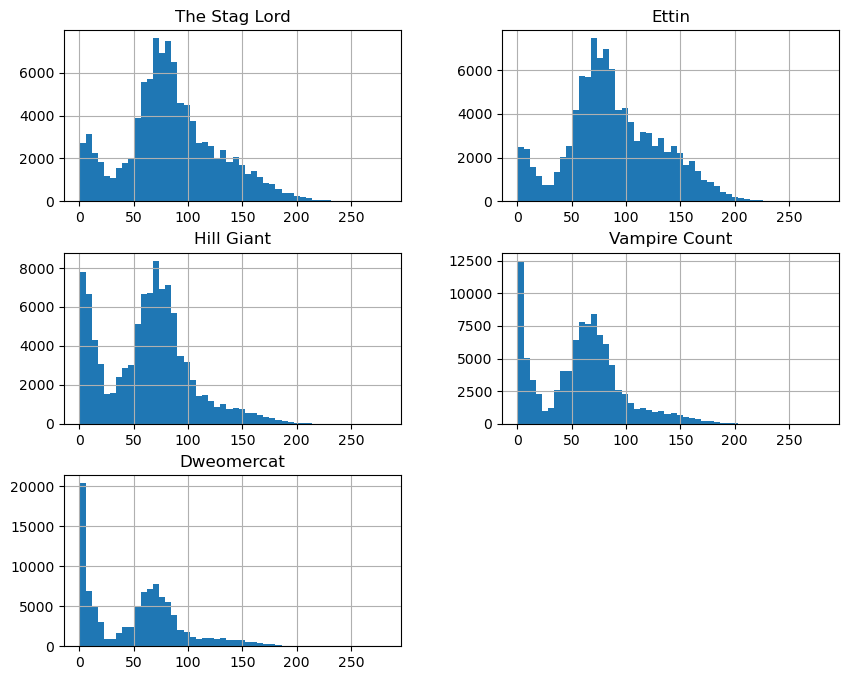

In [16]:
# Damage distribution
_ = final["total_damage"].sum("round").T.to_pandas().hist(bins=50, figsize=(10, 8))

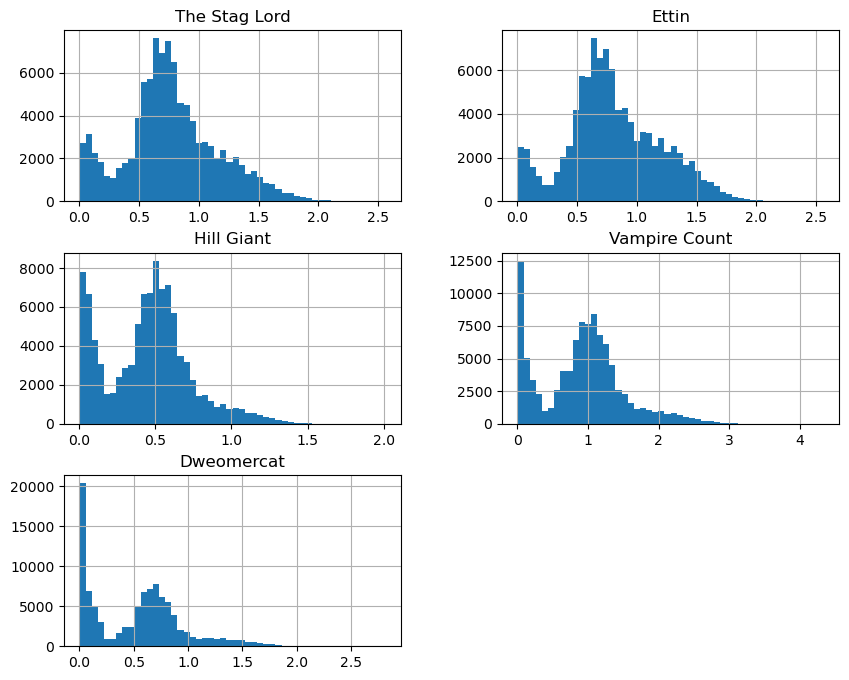

In [17]:
# Damage distribution, normalized by target's hit points total
_ = (final["total_damage"].sum("round") / targets.HP).T.to_pandas().hist(bins=50, figsize=(10, 8))

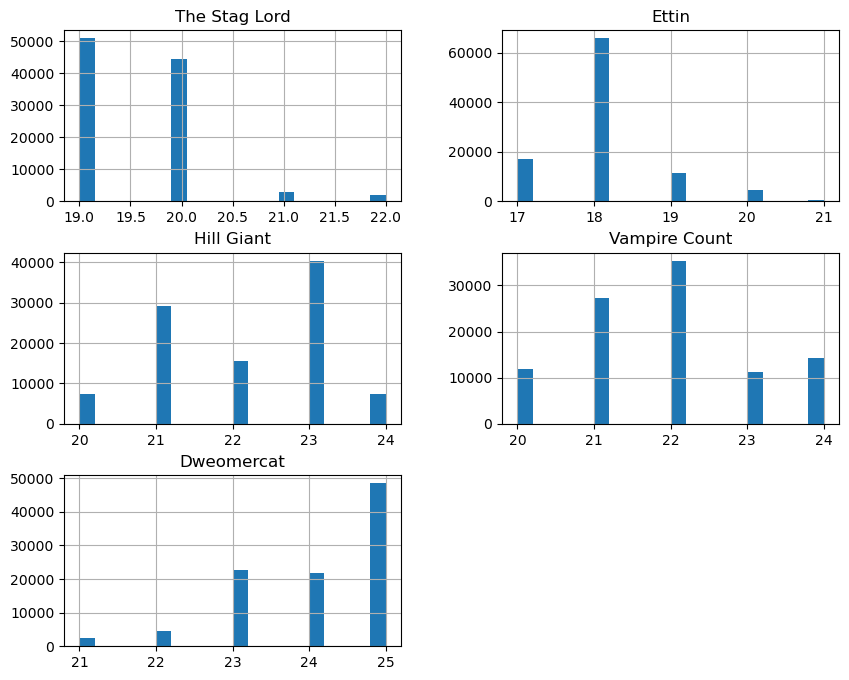

In [18]:
# Worst AC over the 5 rounds
_ = final.min("round")["AC"].T.to_pandas().hist(bins=20, figsize=(10, 8))

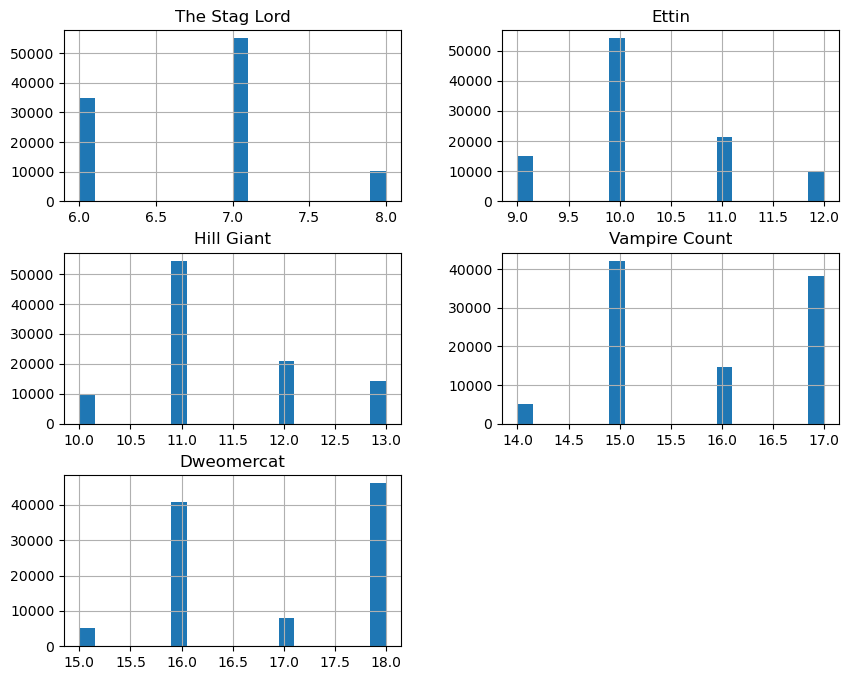

In [19]:
# Worst Will bonus over the 5 rounds
_ = final.min("round")["Will"].T.to_pandas().hist(bins=20, figsize=(10, 8))